# Backpropagation
The backpropagation algorithm is useful to find the weights and biases of a Multi-Layer Perceptron (MLP). It employs the chain rule of the derivative to find the direction in which the weight values need to be modified in order to minimize the error at the output. The algorithm performs in two phases: information is first propagated forward to compute the output of the network for a given input, and the error of the network; then, the error signal is propagated backwards and the network parameters are modified accordingly.

## Loading the packages

In [1]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets

from matplotlib import animation

## Loading the Perceptron code
In order to the make this nothebook smaller, some of the functions (activation functions, and some of the code allowing the visualization of the results) was implemented in a separate python file. You are free to open it if needed.

In [2]:
import mlp as mlp

## The Dataset
The following script allows you to create a 2D dataset by using the mouse. The left click adds points belonging to class A (blue), and the right click adds points belonging to class B (red). You can create as many points as you desire. The final dataset will contain hence three values per point: x coordinate (-1 ≤ x ≤ 1), y coordinate (-1 ≤ y ≤ 1) and the class ∈ {1,-1}.

<IPython.core.display.Javascript object>


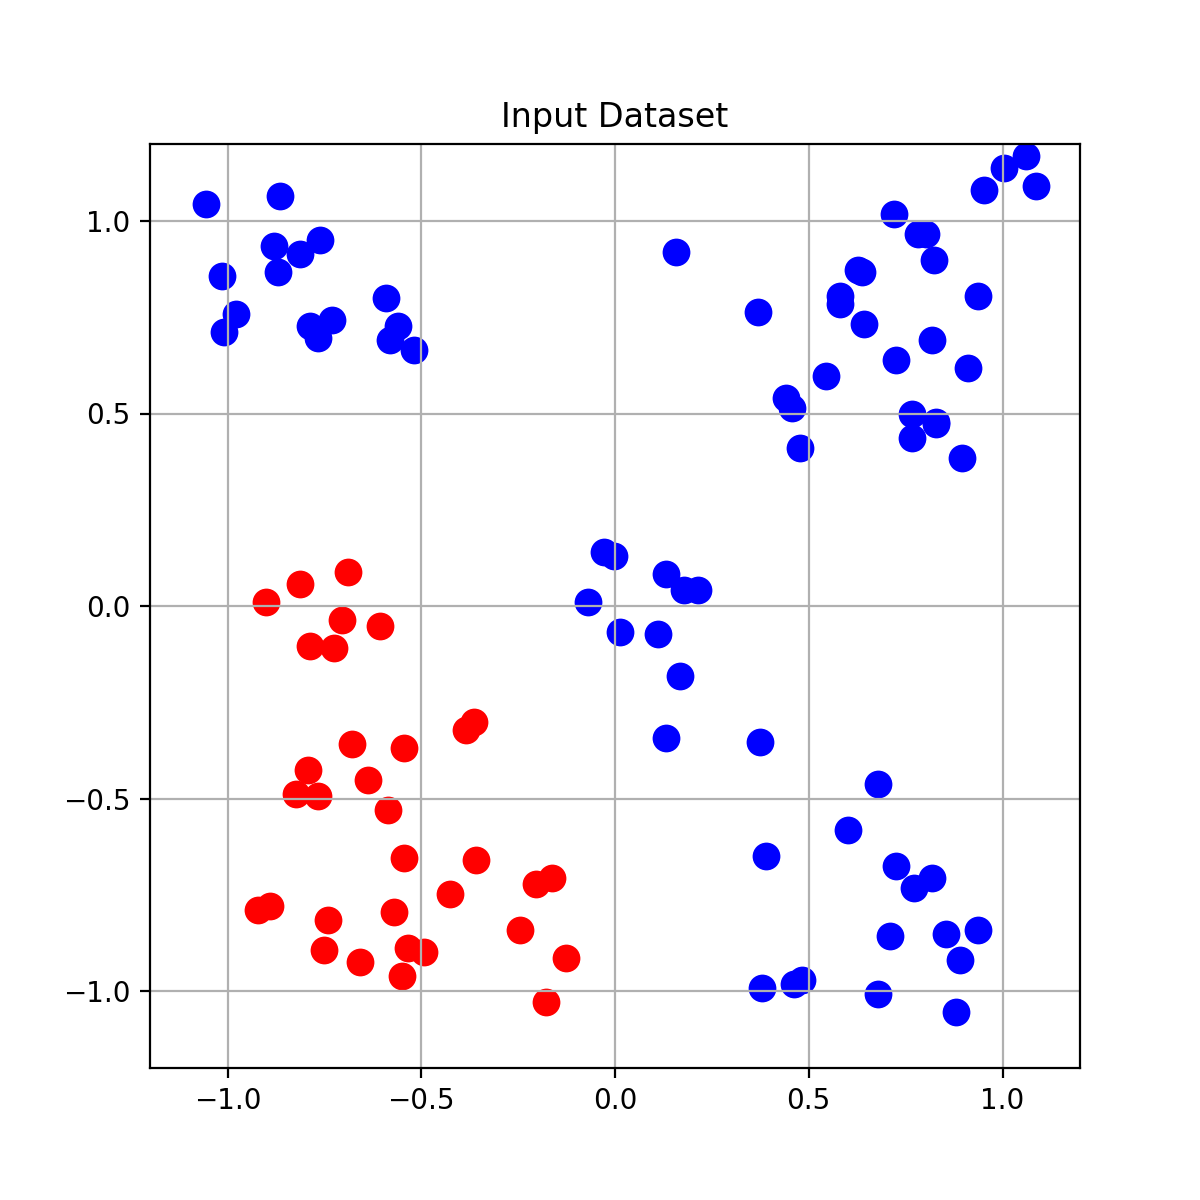

In [3]:
%matplotlib notebook

fig = pl.figure(figsize=(6,6))
pl.title("Input Dataset")
pl.xlim((-1.2,1.2))
pl.ylim((-1.2,1.2))

dataset = []

def onclick(event):
    global dataset
    cx = event.xdata
    cy = event.ydata
    co = event.button
    dataset.append((cx, cy, co-2))

    pl.scatter(cx, cy, c=(['b', 'r'])[co > 2], s=100, lw=0)
    pl.grid(True)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [4]:
fig.canvas.mpl_disconnect(onclick)

This is the dataset you just created. Check that there are no NaNs in the third column. Create once again the dataset if necessary

In [5]:
# Fixing Error with Corrupted Data at None 
for i in range(0,len(dataset)):
    if (dataset[i] == (None, None, -1)) or (dataset[i] == (None, None, 1)):
        del dataset[i]
dataset

[(0.8241129032258065, 0.8991883116883117, -1),
 (0.6279838709677419, 0.8732142857142859, -1),
 (0.7260483870967742, 0.6394480519480519, -1),
 (0.9118548387096777, 0.6186688311688315, -1),
 (0.7673387096774196, 0.4991883116883118, -1),
 (0.5454032258064516, 0.5978896103896107, -1),
 (0.5815322580645161, 0.7849025974025974, -1),
 (0.8189516129032262, 0.6913961038961038, -1),
 (0.8292741935483874, 0.478409090909091, -1),
 (0.4421774193548389, 0.5407467532467534, -1),
 (0.643467741935484, 0.7329545454545454, -1),
 (0.8292741935483874, 0.47321428571428603, -1),
 (0.45766129032258096, 0.5147727272727276, -1),
 (0.5815322580645161, 0.8056818181818182, -1),
 (0.8963709677419356, 0.38490259740259747, -1),
 (0.4783064516129034, 0.41087662337662345, -1),
 (0.36991935483870986, 0.7641233766233766, -1),
 (0.6383064516129036, 0.8680194805194805, -1),
 (0.9376612903225809, 0.8056818181818182, -1),
 (0.7673387096774196, 0.43685064935064943, -1),
 (0.15830645161290335, 0.9199675324675325, -1),
 (0.7828

## Finding the weights by hand
In this section you should try to find the set of weights that makes a MLP to separate the distribution of the two classes you previously defined. Use the sliders to modify the value of each one of the connections and the biases of the MLP while trying to separate the two classes (blue and red). The curve on the right represents the classification error (MSE). If the modifications you provide improve the classification, you should see the error to decrease.

In [6]:
plotter = mlp.MLPPlotter2D(data=np.asarray(dataset))

In [7]:
%matplotlib inline

_= interact(plotter.plot_interactive, **plotter.controls)

interactive(children=(FloatSlider(value=0.5, description='w_x_0', max=2.0, min=-2.0, step=0.01), FloatSlider(v…

## The Backpropagation algorithm
Instead of trying to find the network parameters by hand, we propose to use the backpropagation algorithm. This section shows some details of its implementation. Look at the code in compute_delta_w and try to understand it.

### Derivation using the chain rule

$$ Error = \frac{1}{2} (output - target)^2 $$
$$ \Delta w = - \alpha \cdotp \frac{\partial Error}{\partial w} $$

Output layer
$$ output = f\_act(neta\_h) $$
$$ neta\_h = (w\_h\_0 \cdotp h0) + (w\_h\_1 \cdotp h1) + b_h $$

$$ \frac{\partial Error}{\partial w\_h\_i} = \frac{\partial Error}{\partial output} \cdotp \frac{\partial output}{\partial neta\_h} \cdotp \frac{\partial neta\_h}{\partial w\_h\_i} $$
$$ \frac{\partial Error}{\partial w\_h\_i} = (output - target) \cdotp f\_act'(neta\_h) \cdotp hi $$

$$ \frac{\partial Error}{\partial b\_i} = \frac{\partial Error}{\partial output} \cdotp \frac{\partial output}{\partial neta\_h} \cdotp \frac{\partial neta\_h}{\partial b\_i} $$
$$ \frac{\partial Error}{\partial b\_h} = (output - target) \cdotp f\_act'(neta\_h) \cdotp 1 $$

Hidden layer
$$ hi = f\_act(neta\_i) $$
$$ neta\_i = (x \cdotp w\_x\_i) + (y \cdotp w\_y\_i) + b_i $$

$$ \frac{\partial Error}{\partial w\_x\_i} = \frac{\partial Error}{\partial output} \cdotp \frac{\partial output}{\partial neta\_h} \cdotp \big( \frac{\partial neta\_h}{\partial h\_i} \cdotp \frac{\partial h\_i}{\partial neta\_i} \cdotp \frac{\partial neta\_i}{\partial w\_x\_i} \big) $$
$$ \frac{\partial Error}{\partial w\_x\_i} = (output - target) \cdotp f\_act'(neta\_h) \cdotp \big( w\_h\_i \cdotp f\_act'(neta\_i) \cdotp x \big) $$

$$ \frac{\partial Error}{\partial w\_y\_i} = \frac{\partial Error}{\partial output} \cdotp \frac{\partial output}{\partial neta\_h} \cdotp \big( \frac{\partial neta\_h}{\partial h\_i} \cdotp \frac{\partial h\_i}{\partial neta\_i} \cdotp \frac{\partial neta\_i}{\partial w\_y\_i} \big) $$
$$ \frac{\partial Error}{\partial w\_y\_i} = (output - target) \cdotp f\_act'(neta\_h) \cdotp \big( w\_h\_i \cdotp f\_act'(neta\_i) \cdotp y \big) $$

$$ \frac{\partial Error}{\partial b\_i} = \frac{\partial Error}{\partial output} \cdotp \frac{\partial output}{\partial neta\_h} \cdotp \big( \frac{\partial neta\_h}{\partial h\_i} \cdotp \frac{\partial h\_i}{\partial neta\_i} \frac{\partial neta\_i}{\partial b\_i} \big) $$
$$ \frac{\partial Error}{\partial b\_i} = (output - target) \cdotp f\_act'(neta\_h) \cdotp \big( w\_h\_i \cdotp f\_act'(neta\_i) \cdotp 1 \big) $$



In [8]:
def perceptron(input_values, weights, bias, activation_function):
    neta = np.dot(input_values, weights) + bias
    return activation_function(neta)

def compute_delta_w(input_values, targets, alpha, activation_function, weights, bias):
    x = input_values[:,0]
    y = input_values[:,1]
    
    w_x_0 = weights[0]
    w_x_1 = weights[1]
    w_y_0 = weights[2]
    w_y_1 = weights[3]
    w_h_0 = weights[4]
    w_h_1 = weights[5]
    b_0   = bias[0]
    b_1   = bias[1]
    b_h   = bias[2]
    
    # feedforward
    h_0, h_0_d = perceptron(input_values, [w_x_0, w_y_0], b_0, activation_function)
    h_1, h_1_d = perceptron(input_values, [w_x_1, w_y_1], b_1, activation_function)
    h = np.array([h_0, h_1]).T
    output, output_d = perceptron(h, [w_h_0, w_h_1], b_h, activation_function)

    #output layer
    error = output - targets
    d_w_h_0 = -alpha * (error * output_d * h_0)
    d_w_h_1 = -alpha * (error * output_d * h_1)
    d_b_h   = -alpha * (error * output_d)
    
    #hidden layer
    d_w_x_0 = -alpha * (error * output_d) * (w_h_0 * h_0_d * x)
    d_w_x_1 = -alpha * (error * output_d) * (w_h_1 * h_1_d * x)
    d_w_y_0 = -alpha * (error * output_d) * (w_h_0 * h_0_d * y)
    d_w_y_1 = -alpha * (error * output_d) * (w_h_1 * h_1_d * y)
    d_b_0 = -alpha * (error * output_d) * (w_h_0 * h_0_d)
    d_b_1 = -alpha * (error * output_d) * (w_h_1 * h_1_d)
    
    return (np.vstack((d_w_x_0, d_w_x_1, d_w_y_0, d_w_y_1, d_w_h_0, d_w_h_1)).T, np.vstack((d_b_0, d_b_1, d_b_h)).T)

## Batch learning
In this section you are going to use the backpropagation algorithm to find the weights of a MLP that solves the classification problem you have previously defined. When you launch the cell, the weights and the bias are initialized at random, and the algorithm perform some iterations (NUMBER_OF_EPOCHS) doing the following:
- for each point in the dataset, compute the modifications ($\Delta w$) to be done at each parameter in order to minimize the error function
- sum up all the modifications -> batch policy
- modify the weights and biases of the MLP

The cell records the effects of the modifications performed in a video. Therefore, you can visualize the learning process afterwards.

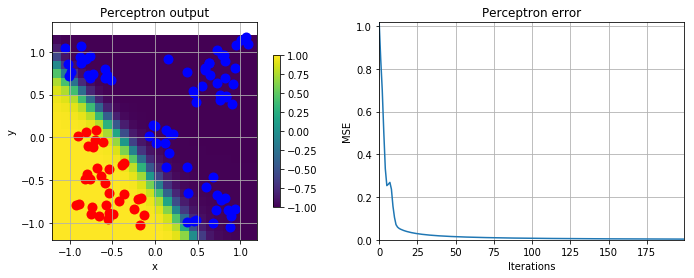

In [9]:
%matplotlib inline

inputs = np.asarray(dataset)[:,0:2]
targets = np.asarray(dataset)[:,2]
weights = np.random.normal(size=6)
bias = np.random.normal(size=3)
activation_function = mlp.htan

ALPHA = 0.015
NUMBER_OF_EPOCHS = 200

fig = pl.figure(figsize=(12, 4))
plotter = mlp.MLPPlotter2D(data=np.asarray(dataset))
plotter.init_animation()

def run_epoch_batch(i, alpha, inputs, targets, activation_function, weights, bias):
    d_weights, d_bias = compute_delta_w(inputs, targets, ALPHA, activation_function, weights, bias)
    weights += np.sum(d_weights, axis=0)
    bias += np.sum(d_bias, axis=0)
    
    return plotter.data2animation(i, inputs, weights, bias, targets, activation_function)

SHOW_VIDEO = False
if SHOW_VIDEO:
    anim = animation.FuncAnimation(fig, run_epoch_batch, fargs=(ALPHA, inputs, targets, activation_function, weights, bias), frames=NUMBER_OF_EPOCHS, interval=20, blit=True)
    mlp.display_animation(anim)
else:
    for i in np.arange(NUMBER_OF_EPOCHS):
        run_epoch_batch(i, ALPHA, inputs, targets, activation_function, weights, bias)


## Exercise
You are free to modify the learning rate (ALPHA) and the number of iterations (NUMBER_OF_EPOCHS).

Try different 2D classification problems and observe the behaviour of the algorithm in terms of:
- Learning rate needed
- Convergence speed
- Oscillations

Bare in mind that, in the current implementation, the parameters (weights and bias) are initialized randomly every time you launch the cell

1. What happens if the boundaries between both classes are well defined?
![separable](separable.png)

2. What happens if the classes overlap? What could you say about oscillations in the error signal?
![overlapping](overlapping.png)

3. What happens if it is not possible to separate the classes with a single line? What could you say about local minima?
![non_separable](non_separable.png)

4. What happens if the points of one of the classes are separated in subgroups (blobs)?
![blobs](blobs.png)